In [1]:
import os
import re
import numpy as np

from robosuite.models.objects import MujocoXMLObject
from robosuite.utils.mjcf_utils import xml_path_completion

from libero.libero.envs.base_object import register_object

import pathlib

from libero.libero.envs.base_object import (
    register_visual_change_object,
    register_object,
)
from libero.libero.utils.mu_utils import register_mu, InitialSceneTemplates
from libero.libero.utils.task_generation_utils import register_task_info, get_task_info, generate_bddl_from_task_info


## Define your own objects
You may want to include more object meshes of yours in the procedural generation pipeline. One option is to include your assets and define your object directly inside the LIBERO codebase. But this can make the whole thing messy. 

Alternatively, you can define the objects inside your custom project repo folder, and define the object classes accordingly. Note that you need to import your defined object classes whenever you run your own stuff. Libero codebase cannot automatically import those that are defined outside its repo.

In the next, we provide an example, assuming you have object meses defined in `custom_assets`. In this example, we assume the generated pddl file will be saved in `custom_pddl`.

In [2]:

class CustomObjects(MujocoXMLObject):
    def __init__(self, custom_path, name, obj_name, joints=[dict(type="free", damping="0.0005")]):
        # make sure custom path is an absolute path
        assert(os.path.isabs(custom_path)), "Custom path must be an absolute path"
        # make sure the custom path is also an xml file
        assert(custom_path.endswith(".xml")), "Custom path must be an xml file"
        super().__init__(
            custom_path,
            name=name,
            joints=joints,
            obj_type="all",
            duplicate_collision_geoms=False,
        )
        self.category_name = "_".join(
            re.sub(r"([A-Z])", r" \1", self.__class__.__name__).split()
        ).lower()
        self.object_properties = {"vis_site_names": {}}

@register_object
class LiberoMug(CustomObjects):
    def __init__(self,
                 name="libero_mug",
                 obj_name="libero_mug",
                 ):
        super().__init__(
            custom_path=os.path.abspath(os.path.join(
                "./", "custom_assets", "libero_mug", "libero_mug.xml"
            )),
            name=name,
            obj_name=obj_name,
        )

        self.rotation = {
            "x": (-np.pi/2, -np.pi/2),
            "y": (-np.pi, -np.pi),
            "z": (np.pi, np.pi),
        }
        self.rotation_axis = None

@register_object
class LiberoMugYellow(CustomObjects):
    def __init__(self,
                 name="libero_mug",
                 obj_name="libero_mug",
                 ):
        super().__init__(
            custom_path=os.path.abspath(os.path.join(
                "./", "custom_assets", "libero_mug_yellow", "libero_mug_yellow.xml"
            )),
            name=name,
            obj_name=obj_name,
        )

        self.rotation = {
            "x": (-np.pi/2, -np.pi/2),
            "y": (-np.pi, -np.pi),
            "z": (np.pi, np.pi),
        }
        self.rotation_axis = None


### Define the scene
Now we define the scene to load the previously defined objects. For more information about the scene genration, please look at `procedural_creation_walkthrough.ipynb`. 

In [9]:
import re
from libero.libero.envs import objects
from libero.libero.utils.bddl_generation_utils import *
from libero.libero.envs.objects import OBJECTS_DICT
from libero.libero.utils.object_utils import get_affordance_regions

from libero.libero.utils.mu_utils import register_mu, InitialSceneTemplates

import random

# initialize random generator
random.seed(a=1) # seed to reproduce randomness

@register_mu(scene_type="kitchen")
class KitchenDemoScene(InitialSceneTemplates):
    def __init__(self):
        
        fixture_num_info = {
            "kitchen_table": 1,
            "wooden_cabinet": 1,
        }

        object_num_info = {
            "libero_mug": 1,
            "libero_mug_yellow": 1,
        }

        super().__init__(
            workspace_name="kitchen_table",
            fixture_num_info=fixture_num_info,
            object_num_info=object_num_info,
        )

    '''
    def randomized_centroid(self, table_dim, region_half_len):
        x_start = -table_dim[0]/2
        x_end = table_dim[0]/2
        y_start = -table_dim[1]/2
        y_end = table_dim[1]/2

        x_chunked_ranges = []
        y_chunked_ranges = []
        x_chunks = [x_start]
        y_chunks = [y_start]
        for region, region_dict in self.regions.items():
            # print(region_dict)
            x_chunks.append(region_dict['ranges'][0][0])
            x_chunks.append(region_dict['ranges'][0][2])
            y_chunks.append(region_dict['ranges'][0][1])
            y_chunks.append(region_dict['ranges'][0][3])
        x_chunks.append(x_end)
        y_chunks.append(y_end)
        # print(x_chunks, y_chunks)
        for i in range(0, len(x_chunks), 2):
            # eliminate chunks that are smaller than object's range
            if abs(x_chunks[i] - x_chunks[i+1]) > (2 * region_half_len):
                # make sure to account for region half len
                x_chunked_ranges.append((x_chunks[i] + region_half_len, x_chunks[i+1] - region_half_len))
        for i in range(0, len(y_chunks), 2):
            # eliminate chunks that are smaller than object's range
            if abs(y_chunks[i] - y_chunks[i+1]) > (2 * region_half_len):
                # make sure to account for region half len
                y_chunked_ranges.append((y_chunks[i] + region_half_len, y_chunks[i+1] - region_half_len))

        # print(x_chunked_ranges, y_chunked_ranges)
        x_choice_idx = np.random.choice(len(x_chunked_ranges))
        y_choice_idx = np.random.choice(len(y_chunked_ranges))

        x_choice = x_chunked_ranges[x_choice_idx]
        y_choice = y_chunked_ranges[y_choice_idx]
        
        # print(x_choice, y_choice)

        return np.random.uniform(low=x_choice[0], high=x_choice[1]), np.random.uniform(low=y_choice[0], high=y_choice[1])
    '''
    def randomized_centroid(self, table_dim, region_half_len):
        # checks if two tuples of range of values overlap
        def overlaps(first_range, second_range):
            if first_range[1] < second_range[0] or first_range[0] > second_range[1]:
                return False
            else:
                return True

        # reduce table dim by full object
        table_dim = tuple(x - 2*region_half_len for x in table_dim)
        count = 0

        while True:
            valid_xy = True
            count += 1
            if count > 100:
                print('most likely the table does not have space')
                return None, None
            
            x = np.random.uniform(-table_dim[0]/2, table_dim[0]/2)
            y = np.random.uniform(-table_dim[1]/2, table_dim[1]/2)

            for region, region_dict in self.regions.items():
                # if both x and y regions overlap true
                new_object_x = (x - region_half_len, x + region_half_len)
                new_object_y = (y - region_half_len, y + region_half_len)
                current_object_x = (region_dict['ranges'][0][0], region_dict['ranges'][0][2])
                current_object_y = (region_dict['ranges'][0][1], region_dict['ranges'][0][3])
                if overlaps(new_object_x, current_object_x) & overlaps(new_object_y, current_object_y):
                    valid_xy = False
            
            # if we complete the loop without overlap
            if valid_xy:
                return x, y

    
    def define_regions(self):
        table_dim = (1.0, 1.2, 0.05)

        x, y = self.randomized_centroid(table_dim, 0.01)
        self.regions.update(
            self.get_region_dict(
                # region_centroid_xy=[0.0, -0.30],
                region_centroid_xy=[x, y],
                region_name="wooden_cabinet_init_region",
                target_name=self.workspace_name,
                region_half_len=0.01,
                yaw_rotation=(np.pi, np.pi),
            )
        )

        x, y = self.randomized_centroid(table_dim, 0.025)
        self.regions.update(
            self.get_region_dict(
                # region_centroid_xy=[0.55, 0.0],
                region_centroid_xy=[x, y],
                region_name="libero_mug_init_region",
                target_name=self.workspace_name,
                region_half_len=0.025,
            )
        )

        x, y = self.randomized_centroid(table_dim, 0.025)
        self.regions.update(
            self.get_region_dict(
                # region_centroid_xy=[-0.1, 0.15],
                region_centroid_xy=[x, y],
                region_name="libero_mug_yellow_init_region",
                target_name=self.workspace_name,
                region_half_len=0.025,
            )
        )
        self.xy_region_kwargs_list = get_xy_region_kwargs_list_from_regions_info(
            self.regions
        )

    @property
    def init_states(self):
        states = [
            ("On", "libero_mug_1", "kitchen_table_libero_mug_init_region"),
            ("On", "libero_mug_yellow_1", "kitchen_table_libero_mug_yellow_init_region"),
            ("On", "wooden_cabinet_1", "kitchen_table_wooden_cabinet_init_region"),
        ]
        return states

./custom_pddl/0/KITCHEN_DEMO_SCENE_libero_demo_behaviors.bddl
./custom_pddl/0/KITCHEN_DEMO_SCENE_libero_demo_behaviors.bddl
./custom_pddl/0/KITCHEN_DEMO_SCENE_libero_demo_behaviors.bddl
./custom_pddl/0/KITCHEN_DEMO_SCENE_libero_demo_behaviors.bddl
Succefully generated: 5
Encountered some failures:  []
./custom_pddl/1/KITCHEN_DEMO_SCENE_libero_demo_behaviors.bddl
./custom_pddl/1/KITCHEN_DEMO_SCENE_libero_demo_behaviors.bddl
./custom_pddl/1/KITCHEN_DEMO_SCENE_libero_demo_behaviors.bddl
./custom_pddl/1/KITCHEN_DEMO_SCENE_libero_demo_behaviors.bddl
Succefully generated: 5
Encountered some failures:  []
./custom_pddl/2/KITCHEN_DEMO_SCENE_libero_demo_behaviors.bddl
./custom_pddl/2/KITCHEN_DEMO_SCENE_libero_demo_behaviors.bddl
./custom_pddl/2/KITCHEN_DEMO_SCENE_libero_demo_behaviors.bddl
./custom_pddl/2/KITCHEN_DEMO_SCENE_libero_demo_behaviors.bddl
Succefully generated: 5
Encountered some failures:  []
./custom_pddl/3/KITCHEN_DEMO_SCENE_libero_demo_behaviors.bddl
./custom_pddl/3/KITCHEN_DEMO_

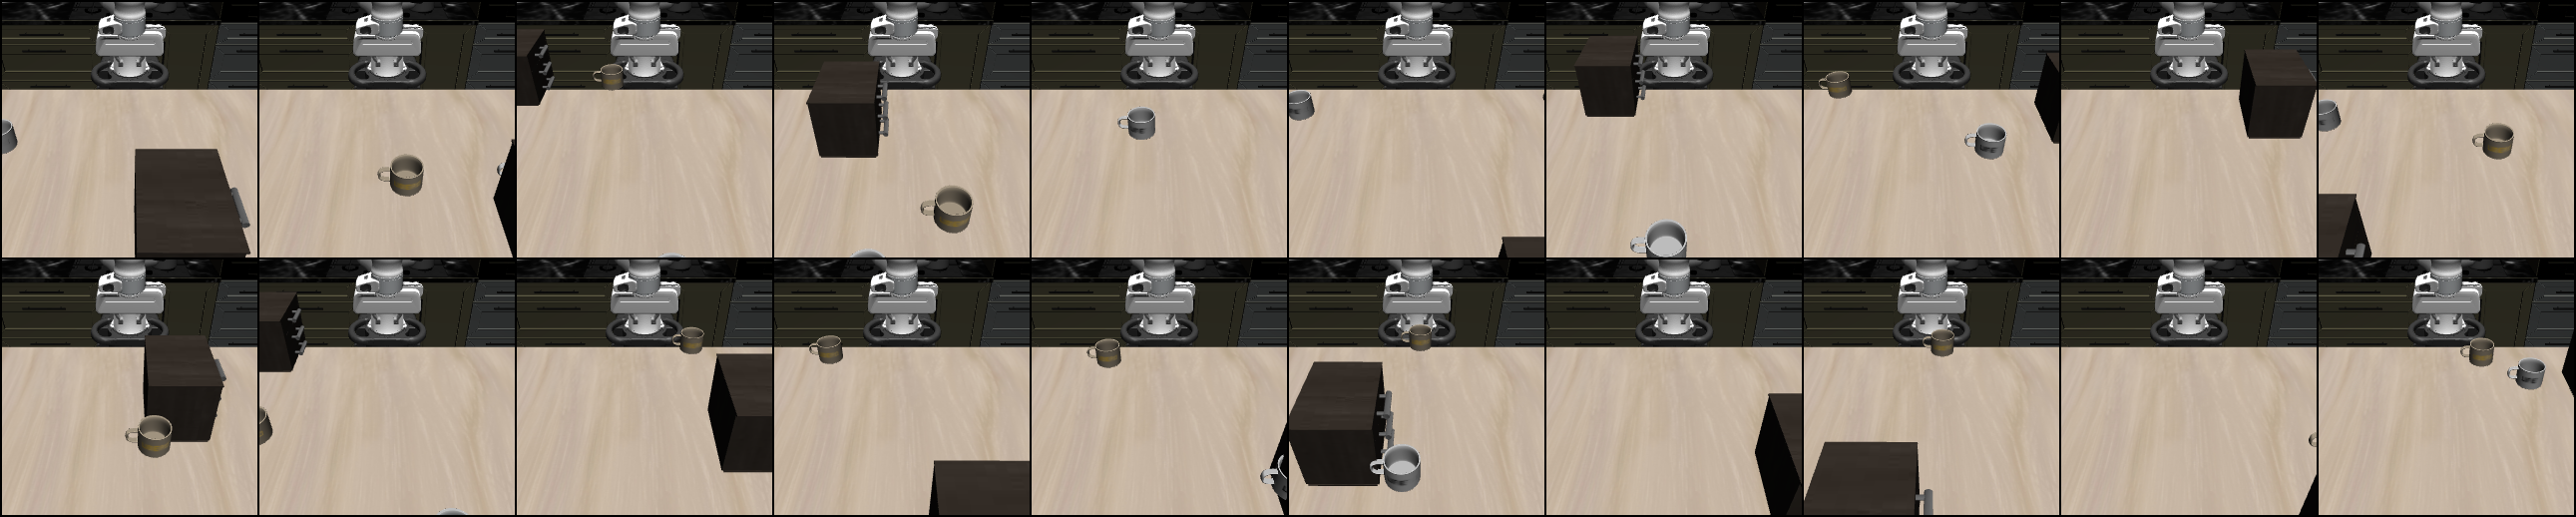

In [12]:
from libero.libero.envs import OffScreenRenderEnv
from IPython.display import display
from PIL import Image

import torch
import torchvision

scene_name = "kitchen_demo_scene"
language = "libero demo behaviors"
register_task_info(language,
                scene_name=scene_name,
                objects_of_interest=[],
                goal_states=[
                    ("Open", "wooden_cabinet_1_top_region"),
                    ("In", "libero_mug_yellow_1", "wooden_cabinet_1_top_region"),
                    ],
)

images = []
for index in range(20):
    YOUR_BDDL_FILE_PATH = f"./custom_pddl/{index}"
    bddl_file_names, failures = generate_bddl_from_task_info(folder=YOUR_BDDL_FILE_PATH)
    
    # print(bddl_file_names)

    print("Encountered some failures: ", failures)

    # with open(bddl_file_names[0], "r") as f:
    #     print(f.read())

    env_args = {
        "bddl_file_name": bddl_file_names[0],
        "camera_heights": 256,
        "camera_widths": 256
    }

    env = OffScreenRenderEnv(**env_args)
    obs = env.reset()
    # display(Image.fromarray(obs["agentview_image"][::-1]))
    images.append(torch.from_numpy(obs["agentview_image"]).permute(2, 0, 1))

def make_grid(images, nrow=8, padding=2, normalize=False, pad_value=0):
    """Make a grid of images. Make sure images is a 4D tensor in the shape of (B x C x H x W)) or a list of torch tensors."""
    grid_image = torchvision.utils.make_grid(images, nrow=nrow, padding=padding, normalize=normalize, pad_value=pad_value).permute(1, 2, 0)
    return grid_image

grid_image = make_grid(images, nrow=10, padding=2, pad_value=0)
display(Image.fromarray(grid_image.numpy()[::-1]))
env.close()
